In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pickle
from tqdm import tqdm

import numpy as np
import jax.numpy as jnp
from jax import jit

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# import darkhistory
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
sys.path.append(os.environ['DH_DIR'])
# import DM21cm
sys.path.append('..')

## 0. Load

In [3]:
! du -smh /data/submit/yitians/DM21cm/transferfunctions/nBs_test/*

3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/archive
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_cdep_dlnz48m_nxreo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_cdep_dlnz48m_renxo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_ctf_dlnz48m_nxreo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_ctf_dlnz48m_renxo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_depgv.npy
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_dep_nxreo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_dep_renxo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tfgv.npy
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tf_nxreo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tf_renxo_ad.p


`phot_depgv.npy` and `phot_tfgv.npy` are ~ (nBs, x, rs, Ein, out)

In [4]:
DATA_DIR = os.environ['DM21CM_DATA_DIR'] + '/transferfunctions/nBs_test'
tf_abscs, tf = pickle.load(open(f'{DATA_DIR}/phot_tf_nxreo_ad.p', 'rb'))
dep_abscs, dep = pickle.load(open(f'{DATA_DIR}/phot_dep_nxreo_ad.p', 'rb'))

print(tf.shape)
print(dep.shape)

(10, 10, 20, 500, 500)
(10, 10, 20, 500, 5)


## 1. Check energy conservation

In [5]:
i, j, k = 3, 4, 5
tf_slice = tf[i,j,k]
dep_slice = dep[i,j,k]
in_eng = tf_abscs['Ein']
out_eng = tf_abscs['out']

tf_fs = np.dot(tf_slice, out_eng)/in_eng
dep_fs = np.sum(dep_slice, axis=-1)/in_eng

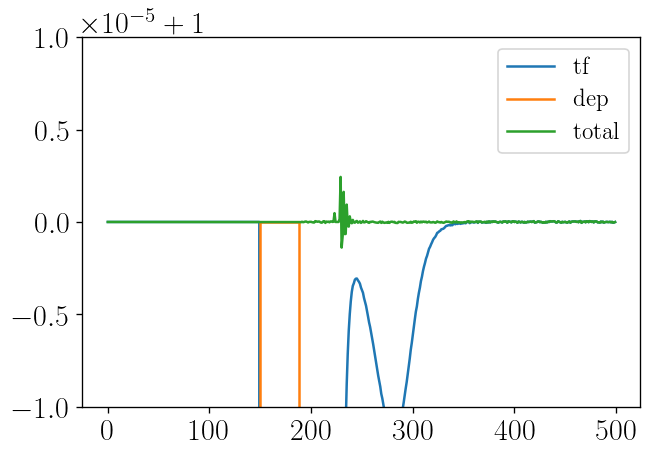

In [6]:
plt.plot(tf_fs, label='tf')
plt.plot(dep_fs, label='dep')
plt.plot(tf_fs+dep_fs, label='total')
plt.ylim(1-1e-5, 1+1e-5)
plt.legend();

## 2. Compounding

In [7]:
def compound(tf, dep, n):
    ctf = np.linalg.matrix_power(tf, n)
    prop_tf = np.zeros_like(tf)
    for i in range(n):
        prop_tf += np.linalg.matrix_power(tf, i)
    cdep = np.dot(prop_tf, dep)
    return ctf, cdep

In [8]:
@jit
def compound_50(tf, dep):
    
    dot = jnp.dot
    
    s2 = jnp.identity(tf.shape[0]) + tf
    p2 = dot(tf, tf)
    s4 = s2 + dot(p2, s2)
    p4 = dot(p2, p2)
    s8 = s4 + dot(p4, s4)
    p8 = dot(p4, p4)
    s16 = s8 + dot(p8, s8)
    p16 = dot(p8, p8)
    s32 = s16 + dot(p16, s16)
    p32 = dot(p16, p16)
    
    p48 = dot(p32, p16)
    p50 = dot(p48, p2)
    s50 = s32 + dot(p32, s16) + dot(p48, s2)
    
    return p50, dot(s50, dep)

In [9]:
%timeit ctf, cdep = compound_50(tf_slice, dep_slice)

11.3 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit ctf, cdep = compound(tf_slice, dep_slice, 50)

901 ms ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
ctf, cdep = compound_50(tf_slice, dep_slice)
#ctf, cdep = compound(tf_slice, dep_slice, 50)
tf_fs = np.dot(ctf, out_eng)/in_eng
dep_fs = np.sum(cdep, axis=-1)/in_eng

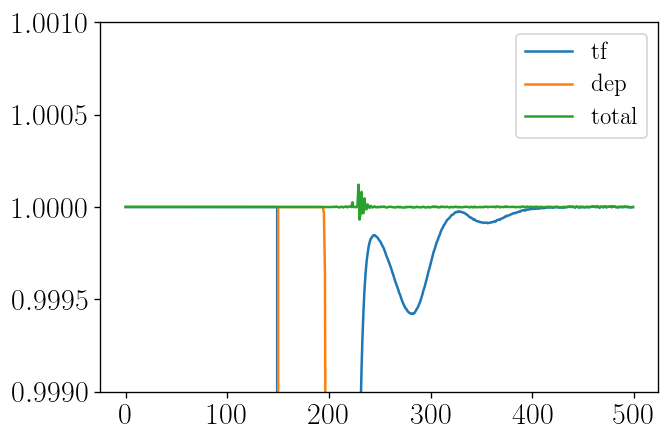

In [12]:
plt.plot(tf_fs, label='tf')
plt.plot(dep_fs, label='dep')
plt.plot(tf_fs+dep_fs, label='total')
plt.ylim(1-1e-3, 1+1e-3)
plt.legend();